source: https://huggingface.co/mattmdjaga/segformer_b2_clothes

In [3]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 31.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 940.5 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is n

In [5]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 524.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 10.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 34.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
!aws s3 ls s3://sagemaker-zara-blouses-generation/loading_dataset/zara_images_initial/

2023-06-28 13:51:55         28 dataset_info.json
2023-06-28 13:44:13      25630 page_1_idx_0_name_BLUSA LINO.jpg
2023-06-28 13:44:13      42632 page_1_idx_1_name_CAMISA OVERSIZE RAYAS.jpg
2023-06-28 13:44:13      48807 page_1_idx_2_name_BLUSA BAJO ASIMÉTRICO.jpg
2023-06-28 13:44:13      47731 page_1_idx_3_name_BLUSA ESTAMPADA BRILLO.jpg
2023-06-28 13:44:13      37754 page_1_idx_4_name_BLUSA RÚSTICA PANELES.jpg
2023-06-28 13:44:13      31334 page_1_idx_5_name_CAMISA LAZO 100_ LINO.jpg
2023-06-28 13:44:13      24195 page_1_idx_6_name_CAMISA CROPPED NUDO.jpg
2023-06-28 13:44:13      70309 page_1_idx_7_name_CAMISA CROPPED NUDO.jpg
2023-06-28 13:44:13      24561 page_1_idx_8_name_CAMISA CROPPED NUDO.jpg
2023-06-28 13:44:13      24077 page_1_idx_9_name_CAMISA 100_ LINO.jpg
2023-06-28 13:44:13      29583 page_2_idx_0_name_CAMISA POPELÍN JOYAS.jpg
2023-06-28 13:44:13      37123 page_2_idx_1_name_CAMISA LINO BAJO ASIMÉTRICO.jpg
2023-06-28 13:44:13      35654 page_2_idx_2_name_CAMISA BORDADOS PE

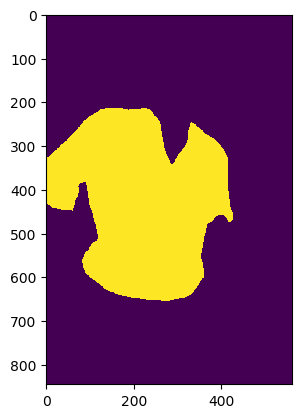

In [12]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt

import torch.nn as nn

extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

image_path = 'images_zara/page_1_idx_0_name_BLUSA LINO.jpg'

image = Image.open(image_path)
inputs = extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

# Extract the upper cloth mask
upper_cloth_label = 4  # Replace with the actual label index for the upper cloth
upper_cloth_mask = pred_seg == upper_cloth_label

# Plot and display the upper cloth mask
plt.imshow(upper_cloth_mask)
plt.show()


In [7]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import numpy as np
import torchvision.utils as vutils


extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

input_folder_path = 's3://sagemaker-zara-blouses-generation/loading_dataset/zara_images_initial/'
output_folder_path = 's3://sagemaker-zara-blouses-generation/loading_dataset/zara_images_final/'

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Iterate over the images in the input folder
for filename in os.listdir(input_folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Update with supported image extensions
        # Read the image
        image_path = os.path.join(input_folder_path, filename)
        image = Image.open(image_path)

        inputs = extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits.cpu()

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

        pred_seg = upsampled_logits.argmax(dim=1)[0]

        # Extract the upper cloth mask
        upper_cloth_label = 4  # Replace with the actual label index for the upper cloth
        upper_cloth_mask = pred_seg == upper_cloth_label

        # Convert the tensor to a NumPy array
        img_upper_cloth_mask = upper_cloth_mask.numpy().astype(np.uint8) * 255

        # Convert the NumPy array to a PIL Image
        image_pil = Image.fromarray(img_upper_cloth_mask)

        # Specify the output image file path with the .jpg extension
        output_image_path = os.path.join(output_folder_path, filename)
        output_image_path = output_image_path.replace('.png', '.jpg')

        # Save the image as JPEG
        image_pil.save(output_image_path)
